In [169]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [170]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)

    
    return df

In [171]:
def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [172]:
# PREPROCESSING
def preprocessing(targets, observed, estimated, test):
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    #print(test_resampled['date_forecast'])

    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
     # Drop the columns not used as features
    columns_to_drop = ['is_day:idx', 'snow_density:kgm3', 'elevation:m']
    test_resampled = test_resampled.drop(columns=columns_to_drop)
    observed_resampled = observed_resampled.drop(columns=columns_to_drop)
    estimated_resampled = estimated_resampled.drop(columns=columns_to_drop)

    # Filter observed and estimated data for April to August
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]

    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values filtering for the same months
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')


    merged_data = merged_data[merged_data['pv_measurement'] != 0]


  
    






    
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    #print(targets.dtypes)
    # Clean up auxiliary columns
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])


    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date

    plot_targets(targets_ny, start_date, end_date)
    if observed_resampled.empty:
        print(f"observed_resampled is empty for location ")
    
    # Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast'])

    print(test_resampled.dtypes)
    print(filtered_data.dtypes)
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

<ipython-input-172-816faa7cf3be>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
<ipython-input-172-816faa7cf3be>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()


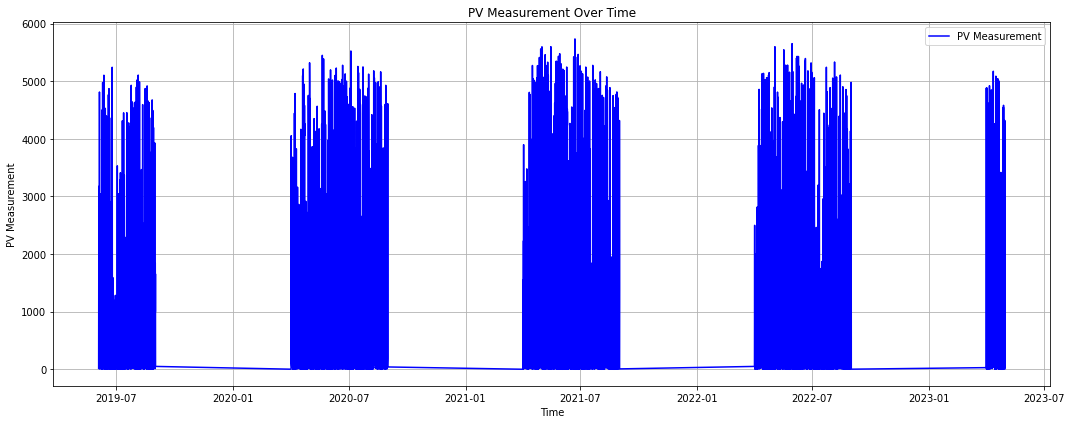

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

/Users/kaja/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


200:	learn: 361.8015968	total: 764ms	remaining: 3.04s
400:	learn: 328.3807182	total: 1.49s	remaining: 2.23s
600:	learn: 307.3153287	total: 2.17s	remaining: 1.44s
800:	learn: 289.5345525	total: 2.99s	remaining: 744ms
999:	learn: 277.6598431	total: 3.69s	remaining: 0us


<ipython-input-172-816faa7cf3be>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
<ipython-input-172-816faa7cf3be>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()


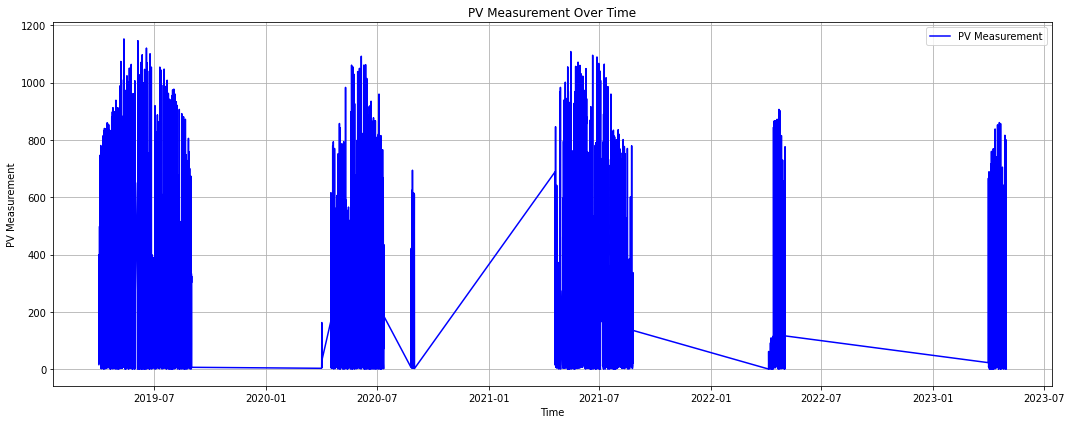

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

/Users/kaja/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


200:	learn: 63.0675503	total: 709ms	remaining: 2.82s
400:	learn: 55.6470080	total: 1.43s	remaining: 2.14s
600:	learn: 50.6257755	total: 2.07s	remaining: 1.38s
800:	learn: 47.0833151	total: 2.83s	remaining: 704ms
999:	learn: 44.5411153	total: 3.47s	remaining: 0us


<ipython-input-172-816faa7cf3be>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
<ipython-input-172-816faa7cf3be>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()


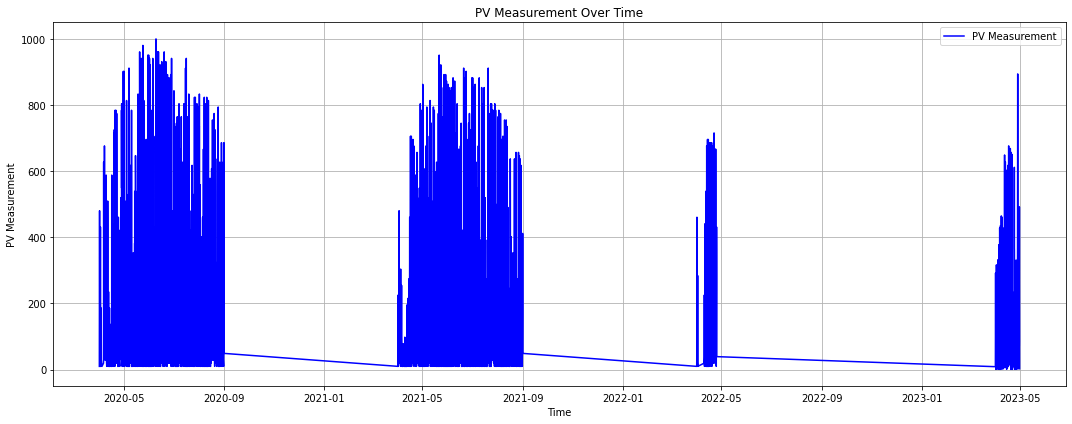

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

/Users/kaja/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


200:	learn: 54.0145724	total: 716ms	remaining: 2.84s
400:	learn: 46.3458403	total: 1.47s	remaining: 2.2s
600:	learn: 41.3751246	total: 2.11s	remaining: 1.4s
800:	learn: 38.3772795	total: 2.71s	remaining: 675ms
999:	learn: 36.1903036	total: 3.42s	remaining: 0us


In [173]:
locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = []

for loc in locations:
   
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    #print(X_test_estimated.columns)  


   # Preprocess data
    X_train, X_test, is_day_feature, targets_ny = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y = targets_ny['pv_measurement']
    print(X_train.columns.tolist())

    '''# Ensure X and y have the same length
    min_length = min(len(X_train), len(y))
    X_train, y = X_train.iloc[:min_length], y[:min_length]'''
    
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and Train model
    model = CatBoostRegressor(loss_function='MAE', learning_rate=0.1, verbose=200)
    model.fit(X_train, y)

    predictions = model.predict(X_test)  # Ensure preprocessing of X_test_estimated before using it.
    #final_predictions = predictions['prediction_label']

    adjusted_final_predictions = predictions * is_day_feature['is_day:idx']
    #adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
    #all_predictions.append(adjusted_final_predictions)

    all_predictions.append(adjusted_final_predictions)



In [174]:
final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('catboost_predictions.csv', index=False)